# Mortalidade

A série temporal tem frequência diária e diz respeito ao número de óbito no Brasil do período de 01/01/2018 a 31/12/2023. O site que disponibiliza esses dados é [Portal de Dados Abertos do SUS](https://dadosabertos.saude.gov.br/dataset/sim). O objetivo é aplicar técnicas de aprendizado de máquina para entender como funciona o aprendizado supervisionados de modelos regressivos com previsão de séries temporais.

O processamento desses dados foi baseado no site: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

Bibliotecas

Essa é do nosso grande amigo Wesley 😲

In [ ]:
!pip install git+https://github.com/zairobastos/LLM4Time.git

In [1]:
from math import sqrt
from numpy import mean
import numpy as np
import pandas as pd
from pandas import read_csv

# Métricas
from sklearn.metrics import mean_squared_error, r2_score

# Modelos
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Cálculo de características do dataset
from statsmodels.tsa.stattools import adfuller

# Para plotar
from llm4time.visualization import plots
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy'

Visualização do dataset
- Notas: Pico claro de 2020 a 2022 devido a Covid

In [ ]:
# Carrega o csv
df = pd.read_csv(f"..\\data\\raw\\mortalidade_2018_a_2023.csv")

# Plota a série temporal
plots.plot_time_series(title="Série diária", ts=df)

         date  value
0  2018-01-01   3848
1  2018-01-02   3548
2  2018-01-03   3487
3  2018-01-04   3431
4  2018-01-05   3453


In [116]:
df.describe()

,value
count,2191.000000
mean,4137.776814
std,682.105112
min,3223.000000
25%,3710.500000
50%,3944.000000
75%,4374.500000
max,7662.000000


In [105]:
df.isnull().sum()

,0
date,0
value,0


Informações sobre o dataset

Uma série é estacionária se tem: média constante, variância constante e autocorrelação depende só do lag (não do tempo)

Interpretação:

* p-value < 0.05 → estacionária

* p-value ≥ 0.05 → não estacionária

**OBS: Muitos modelos assumem estacionariedade**

In [100]:
result = adfuller(df['value'], regression='ct')

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -3.324990322942126
p-value: 0.0622460373972689


**Modelo de Decomposição Aditiva**

O modelo de decomposição aditiva assume que uma série temporal pode ser representada como a soma de três componentes principais:

Série = Trend + Seasonal + Residual

Cada componente captura um tipo distinto de comportamento presente nos dados.


---



* Trend (Tendência)

A tendência representa o comportamento de longo prazo da série temporal, descrevendo variações graduais e persistentes ao longo do tempo, como crescimento, declínio ou mudanças estruturais.

No resultado obtido, observa-se uma tendência claramente não estacionária, com um crescimento progressivo até aproximadamente a metade da série, seguido por uma redução e posterior estabilização. Esse comportamento indica que o nível médio da série varia ao longo do tempo, confirmando a presença de dependência temporal de longo prazo.


---


* Seasonal (Sazonalidade)

A sazonalidade captura padrões periódicos que se repetem em intervalos regulares e conhecidos, como ciclos diários, semanais ou anuais.

No gráfico da componente sazonal, observa-se um padrão recorrente com amplitude relativamente constante, caracterizando uma sazonalidade bem definida. Isso indica que a série apresenta flutuações sistemáticas que se repetem ao longo do tempo, independentemente da tendência de longo prazo.


---



* Residual (Resíduo)

O resíduo corresponde à parte da série que não é explicada nem pela tendência nem pela sazonalidade. Ele agrega ruído aleatório, choques externos e variações irregulares.

No componente residual, verifica-se a presença de flutuações de alta variância e picos acentuados, sugerindo a ocorrência de eventos inesperados ou anomalias. Esses choques explicam parte da dificuldade dos modelos em reduzir significativamente o erro de previsão, mesmo ao considerar múltiplos atrasos temporais.

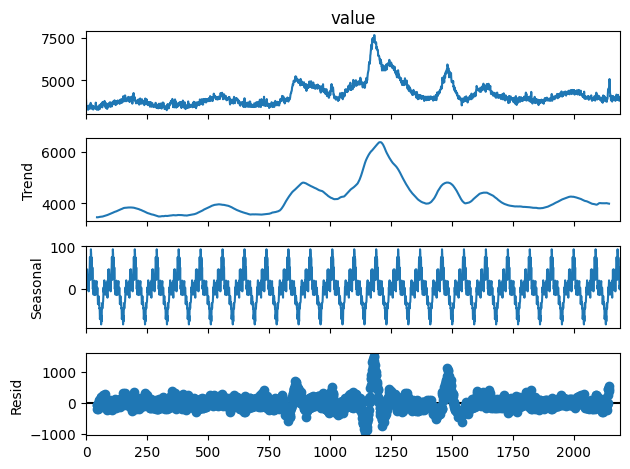

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df['value'], model='additive', period=90)

decomp.plot()
plt.show()

Autocorrelação (ACF)

O gráfico da função de autocorrelação (ACF) indica forte dependência temporal na série.

O gráfico de autocorrelação mostra valores elevados nos primeiros lags, indicando forte dependência temporal de curto prazo e presença de tendência. A partir de aproximadamente lag 100, a autocorrelação passa a ficar dentro do intervalo de confiança, sugerindo que essas dependências deixam de ser estatisticamente significativas.

Apesar disso, observa-se um novo aumento da autocorrelação próximo ao lag 365, evidenciando uma sazonalidade anual nos dados, o que justifica a escolha de nlags = 365.

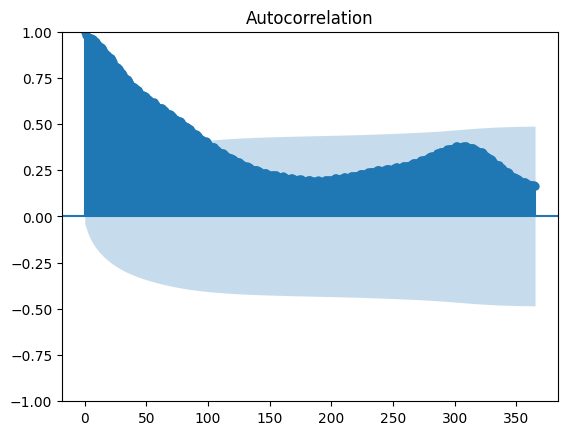

In [101]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df['value'], lags=365)
plt.show()

Definição dos hiper parâmetros e dos modelos

Neste trabalho, foram avaliados modelos de aprendizado de máquina para previsão de séries temporais, especificamente Support Vector Regression (SVR), Random Forest Regressor (RF) e XGBoost Regressor (XGB). Como esses modelos não são inerentemente conscientes da ordem temporal dos dados, a série foi previamente transformada em um problema de aprendizado supervisionado por meio da utilização de observações defasadas (lags). A avaliação dos modelos foi conduzida utilizando walk-forward validation, de forma a preservar a causalidade temporal e evitar vieses otimistas decorrentes de vazamento de informação.

In [106]:
# Cria um array com os valores da série temporal
data = df['value'].values.flatten()

# Número de valores que serão previstos
n_test = 365

# Quais os valores serão utilizados para referência. Ex: [1] - somente o valor anterior, [1, 2, 3] - os três valores anteriores
lag_configs = [
    [1],
    [1, 2, 3],
    [1, 3, 7],
    [1, 7, 14, 30],
    [1, 7, 14, 30, 365],
]

models = {
    'xgb': XGBRegressor(random_state=42),
    'rf': RandomForestRegressor(random_state=42),
    'svr': SVR()
}

Podemos reestruturar este conjunto de dados de séries temporais como um problema de aprendizado supervisionado, utilizando o valor do passo de tempo anterior para prever o valor no próximo passo de tempo. Essa técnica é comumente chamada de Método de Janela Deslizante (Sliding Window Method). Em vez de termos apenas uma sequência de números, criamos pares de "Entrada" ($X$) e "Saída" ($y$). Ao reorganizar o conjunto de dados de série temporal desta forma, os dados ficariam da seguinte maneira:

Exemplo:

data = [1,2,3,4,5,6] e n_lag = 3 (Pega os três imediatamente anteriores)

X = {
  [1,2,3],
  [2,3,4],
  [3,4,5]
  }

y = [4,5,6]

A ordem importa!

In [73]:
def series_to_supervised(data, lags):
    X, y = [], []
    max_lag = max(lags)

    for i in range(max_lag, len(data)):
        X.append([data[i - lag] for lag in lags])
        y.append(data[i])

    return np.array(X), np.array(y)

**Walk-Forward Validation**

Podemos validar nosso modelo de série temporal utilizando a técnica de Walk-Forward Validation. Em vez de treinar o modelo uma única vez, nós simulamos a realidade: o modelo treina com o que já aconteceu e "caminha" para frente, testando no próximo passo disponível. Conforme novos dados "chegam", eles são incorporados ao treino para a próxima previsão.

Exemplo Prático: Imagine que temos os dados de 6 meses e queremos validar o modelo mês a mês.

Passo 1:

Treino: [Mês 1]

Teste: [Mês 2]

Passo 2:

Treino: [Mês 1, Mês 2]

Teste: [Mês 3]

Passo 3:

Treino: [Mês 1, Mês 2, Mês 3]

Teste: [Mês 4]

E assim por diante, até o final do conjunto de dados.

In [122]:
def walk_forward_validation(data, n_test, lags):
    train, test = data[:-n_test], data[-n_test:]

    X_train, y_train = series_to_supervised(train, lags)

    rows = []

    for name, model in models.items():
        model.fit(X_train, y_train)

        history = list(train)
        predictions = []

        for i in range(len(test)):
            x_input = np.array([[history[-lag] for lag in lags]])
            yhat = model.predict(x_input)
            predictions.append(yhat[0])
            history.append(test[i])

        fig = plots.plot_forecast(title= f"Predição do modelo {name} para lag {lags}", y_val= test, y_pred= predictions)
        fig.show()

        rmse = sqrt(mean_squared_error(test, predictions))
        r2 = r2_score(test, predictions)

        rows.append({
            'lags': str(lags),
            'model': name,
            'rmse': rmse,
            'r2': r2
        })

        print(f"{name} → RMSE: {rmse:.3f}, R²: {r2:.3f}")

    return pd.DataFrame(rows)


In [127]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np
import pandas as pd

def walk_forward_validation(data, n_test, lags):
    train, test = data[:-n_test], data[-n_test:]

    X_train, y_train = series_to_supervised(train, lags)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    rows = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_scaled)

        history = list(train)
        predictions = []

        for i in range(len(test)):
            x_input = np.array([[history[-lag] for lag in lags]])
            x_input_scaled = scaler_X.transform(x_input)

            yhat_scaled = model.predict(x_input_scaled)
            yhat = scaler_y.inverse_transform(yhat_scaled.reshape(-1, 1))[0, 0]

            predictions.append(yhat)
            history.append(test[i])


        fig = plots.plot_forecast(
            title=f"Predição do modelo {name} para lag {lags}",
            y_val=test,
            y_pred=predictions
        )
        fig.show()

        rmse = sqrt(mean_squared_error(test, predictions))
        r2 = r2_score(test, predictions)

        rows.append({
            'lags': str(lags),
            'model': name,
            'rmse': rmse,
            'r2': r2
        })

        print(f"{name} → RMSE: {rmse:.3f}, R²: {r2:.3f}")

    return pd.DataFrame(rows)


# Resultados

In [128]:
df_results = pd.DataFrame()

for lags in lag_configs:
  print(f"\nLags usados: {lags}")
  df_lag = walk_forward_validation(data, n_test, lags)
  df_results = pd.concat([df_results, df_lag], ignore_index=True)


Lags usados: [1]


xgb → RMSE: 130.777, R²: 0.630


rf → RMSE: 144.422, R²: 0.549


svr → RMSE: 122.667, R²: 0.674

Lags usados: [1, 2, 3]


xgb → RMSE: 125.014, R²: 0.662


rf → RMSE: 122.104, R²: 0.677


svr → RMSE: 120.326, R²: 0.687

Lags usados: [1, 3, 7]


xgb → RMSE: 124.397, R²: 0.665


rf → RMSE: 123.563, R²: 0.670


svr → RMSE: 117.329, R²: 0.702

Lags usados: [1, 7, 14, 30]


xgb → RMSE: 127.269, R²: 0.649


rf → RMSE: 125.576, R²: 0.659


svr → RMSE: 116.729, R²: 0.705

Lags usados: [1, 7, 14, 30, 365]


xgb → RMSE: 130.946, R²: 0.629


rf → RMSE: 121.699, R²: 0.679


svr → RMSE: 125.503, R²: 0.659


O desempenho dos modelos foi avaliado utilizando as métricas RMSE (Root Mean Squared Error), MAE (Mean Absolute Error) e R² (Coeficiente de Determinação). O RMSE foi adotado como métrica principal, pois penaliza erros grandes de forma mais severa e fornece uma medida do erro médio na mesma escala da série original, sendo particularmente adequado para aplicações de previsão onde grandes desvios são indesejáveis.

Cria um ranking dos modelos avaliados.
A ordenação é feita principalmente pelo RMSE (quanto menor, melhor)
e, em caso de empate, pelo R² (quanto maior, melhor).
O índice é reiniciado apenas para facilitar a visualização.

In [129]:
df_rank = df_results.sort_values(
    by=["rmse", "r2"],
    ascending=[True, False]
).reset_index(drop=True)

df_rank

,lags,model,rmse,r2
0,"[1, 7, 14, 30]",svr,116.729131,0.705123
1,"[1, 3, 7]",svr,117.329140,0.702084
2,"[1, 2, 3]",svr,120.325972,0.686671
3,"[1, 7, 14, 30, 365]",rf,121.699446,0.679477
4,"[1, 2, 3]",rf,122.103631,0.677344
5,[1],svr,122.667481,0.674357
6,"[1, 3, 7]",rf,123.562513,0.669588
7,"[1, 3, 7]",xgb,124.396927,0.665110
8,"[1, 2, 3]",xgb,125.014329,0.661778
9,"[1, 7, 14, 30, 365]",svr,125.502630,0.659131


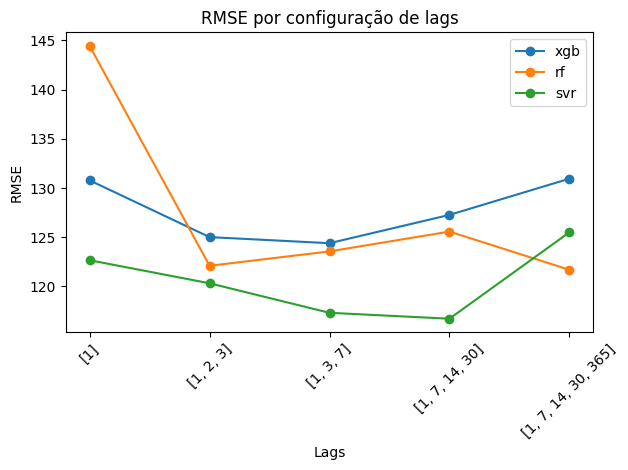

In [130]:
df_results['lags_str'] = df_results['lags'].astype(str)

plt.figure()
plt.xticks(rotation=45)
for model in df_results['model'].unique():
    subset = df_results[df_results['model'] == model]
    plt.plot(subset['lags_str'], subset['rmse'], marker='o', label=model)

plt.xlabel("Lags")
plt.ylabel("RMSE")
plt.title("RMSE por configuração de lags")
plt.legend()
plt.tight_layout()
plt.show()
